In [72]:
#Формирование словаря следующих слов
def find_bigrams(my_word, f, k):
    my_word2 = my_word + "'s"
    i_find = False
    my_words_dict = {}
    for line in f:
        list_words = line.split()
        for word in list_words:
            if i_find:
                if word in my_words_dict:
                    my_words_dict[word] += 1
                else:
                    my_words_dict[word] = 1
                i_find = False
                continue
            if word == my_word or word == my_word2:
                i_find = True
        i_find = False
    
    for key in list(my_words_dict):
        if my_words_dict[key] < k:
            del my_words_dict[key]

    return my_words_dict

In [73]:
f = open('text_sent_1.txt', 'r')
word = 'generalized'
my_words_dict = find_bigrams(word, f, 5)
print(len(my_words_dict))
print(my_words_dict)
f.close()

5
{'additive': 37, 'association': 9, 'linear': 11, 'cross': 7, 'item': 6}


In [74]:
import pandas as pd

Получили дата фрейм всех биграм слов

In [75]:
df = pd.DataFrame(list(my_words_dict.items()), columns=['second word', 'count'])
df

,second word,count
0,additive,37
1,association,9
2,linear,11
3,cross,7
4,item,6


In [76]:
df.sort_values(by=['count'], ascending=False)

,second word,count
0,additive,37
2,linear,11
1,association,9
3,cross,7
4,item,6


In [77]:
df

,second word,count
0,additive,37
1,association,9
2,linear,11
3,cross,7
4,item,6


Теперь займёмся созданием для каждого слова таблицы сопряжённости. Для этого посчитаем сначала общее количество биграм в тексте


In [78]:
n_bigrams = 0
k = 0
i = 0
f = open('text_sent_1.txt')
for line in f:
    i += 1
    if(len(line.split()) == 2 and line.find("'")!=-1):
        print(line, i)
        k += 1
    n_bigrams += len(line.split(' ')) - 1

f.close()
n_bigrams, k


and d'aspremont
 10732


(176569, 1)

Теперь для каждого слова из датафрейма посчитаем сколько раз оно встречается в тексте не на первой позиции.


In [79]:
f = open('text_sent_1.txt')
n_words = [0] * len(df)
i = 0
for word in df['second word']:
    f.seek(0) #Возвращаемся в начало файла
    for line in f: # Пробегаемся по всему файлу
        list_line = line.split()
        n_words[i] += line.count(word)
        if len(line) > 1 and list_line[0] == word: 
            n_words[i] -= 1
    i += 1
n_words

[189, 69, 774, 233, 52]

Добавим этот столбец к нашему дата фрейму


In [80]:
df['all second word'] = n_words

Теперь посчитаем количество биграм без первого слова

In [81]:
df['without first word'] = df['all second word'] - df['count']

Посчитаем количество в тексте 1ого слова

In [82]:
first_count = df['count'].sum()

Посчитаем количество без 2го слова для каждого 2ого слова, но с первым нашем словом



In [83]:
df['without second word'] = first_count - df['count']

Посчитаем количество биграм без второго и первого слов

In [84]:
df['without first and second'] = n_bigrams - df['count'] - df['without first word'] - df['without second word']

In [85]:
df

,second word,count,all second word,without first word,without second word,without first and second
0,additive,37,189,152,33,176347
1,association,9,69,60,61,176439
2,linear,11,774,763,59,175736
3,cross,7,233,226,63,176273
4,item,6,52,46,64,176453


In [86]:
first_count

70

А теперь посчитаем коэффициент стьюдента


In [87]:
import numpy as np

In [88]:
avr_x = df['count'] / df['without first and second']
nu = first_count * df['all second word'] / (n_bigrams**2)
df['t'] = (avr_x - nu) / np.sqrt(avr_x * (1 - avr_x) / n_bigrams)

In [89]:
df[['second word', 't']].sort_values(by=['t'], ascending=False)

,second word,t
0,additive,6.074917
2,linear,3.232277
1,association,2.992066
3,cross,2.613140
4,item,2.441923


Теперь упорядочим значения по коэфициенту t

In [90]:
df.sort_values(by=['t'], ascending=False)

,second word,count,all second word,without first word,without second word,without first and second,t
0,additive,37,189,152,33,176347,6.074917
2,linear,11,774,763,59,175736,3.232277
1,association,9,69,60,61,176439,2.992066
3,cross,7,233,226,63,176273,2.613140
4,item,6,52,46,64,176453,2.441923


Теперь посчитаем статистику хи квадрат

In [91]:
t1 = n_bigrams * (df['count'] * df['without first and second'] - df['without second word'] * df['without first word'])**2
t2 = ((df['count'] + df['without second word']) * (df['count'] + df['without first word']) 
      * (df['without second word'] + df['without first and second']) * (df['without second word'] + df['without first and second']))
df['chi2'] = t1 / t2
df[['second word', 'chi2']].sort_values(by='chi2',ascending=False)

,second word,chi2
0,additive,18235.914529
1,association,2945.423974
4,item,1735.329395
3,cross,517.923177
2,linear,375.926329


Теперь посчитаем коэффициент фишера

In [92]:
from math import comb

Для начала забьём формулу распределения абсолютной частоты

In [93]:
def abs_quens(z, c1, c2, N):
    print(c2, N)
    print(comb(c2, N))
    return comb(c1, z) * comb(c2 - z, N) / comb(c2, N)

Теперь посчитаем коэффициент фишера

In [94]:
def fisher(c1, c2, c12, N):
    s = 0
    for i in range(c12 + 1):
        s += abs_quens(i, c1, c2, N)
    return 1 - s


    Теперь когда все вспомогательные функции готовы, приступим к подсчёту коэффициента фишера для каждого словосочетания

In [95]:
# importing packages 
import scipy.stats as stats 

In [96]:

F = []
df1 = df.reset_index()
for index, line in df1.iterrows():
    data = [[line['count'], line['without second word']], [line['without first word'], line['without first and second']]]
    odd_ratio, p_value = stats.fisher_exact(data) 
    F.append(p_value)
df['fisher'] = F
df[['second word', 'fisher']].sort_values(by=['fisher'], ascending=False)


,second word,fisher
3,cross,7.107536e-12
4,item,6.252833e-14
2,linear,1.831525e-14
1,association,7.870888e-21
0,additive,2.780909e-92


In [97]:
#Уровень значимости
alpha = 1 - 0.01
t = stats.t.ppf(alpha, df=n_bigrams-1)
chi2KR = stats.chi2.ppf(alpha, df=1)

df['t>tкр'] = df['t'] > t
df['ch2>ch2кр'] = df['chi2'] > chi2KR
df['F>0.005'] = df['fisher'] > 0.005
df

,second word,count,all second word,without first word,without second word,without first and second,t,chi2,fisher,t>tкр,ch2>ch2кр,F>0.005
0,additive,37,189,152,33,176347,6.074917,18235.914529,2.780909e-92,True,True,False
1,association,9,69,60,61,176439,2.992066,2945.423974,7.870888e-21,True,True,False
2,linear,11,774,763,59,175736,3.232277,375.926329,1.831525e-14,True,True,False
3,cross,7,233,226,63,176273,2.613140,517.923177,7.107536e-12,True,True,False
4,item,6,52,46,64,176453,2.441923,1735.329395,6.252833e-14,True,True,False


Значит гипотезу о связи слова generalized отвергаем со всеми словами из полученной выборки, кроме слова item.


А вообще, в документации написанно, что распределение считается по такой формулке: 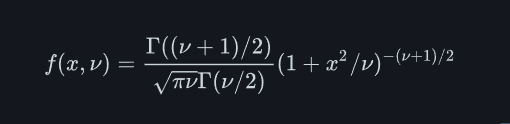

In [98]:
t,chi2KR, n_bigrams

(2.326368993986917, 6.6348966010212145, 176569)

In [99]:
df[['second word', 't>tкр', 'ch2>ch2кр','F>0.005']]

,second word,t>tкр,ch2>ch2кр,F>0.005
0,additive,True,True,False
1,association,True,True,False
2,linear,True,True,False
3,cross,True,True,False
4,item,True,True,False
